# Classify images using pre-trained model

There are many useful models before you do hard work. (But it is important that we learnin how to make models) But in general cases, we can use useful model that made by created by scholars.

In [27]:
import (
    "fmt"
    "os"
    "log"
    "image"
    "bufio"
    _ "image/png"
)

In [28]:
f, err := os.Open("grace_hopper.png")
if err != nil {
    log.Fatal(err)
}

In [29]:
img, _, err := image.Decode(f)
if err != nil {
    log.Fatal(err)
}

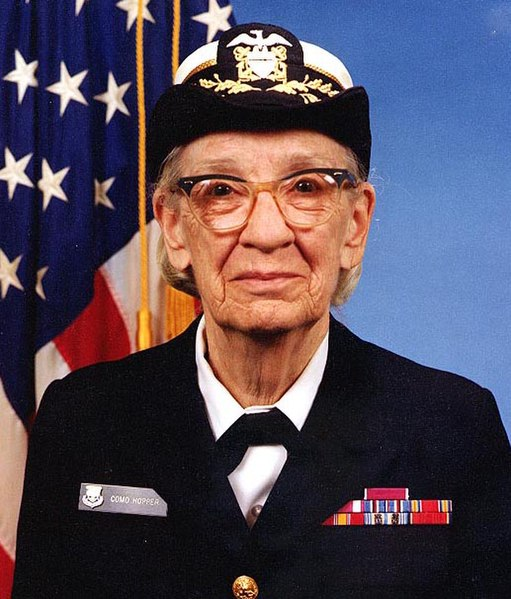

In [30]:
img

This tutorial predict this image from pre-trained model file.

In [5]:
import "github.com/mattn/go-tflite"

Using mobilenet_quant_v1_224. If you want to try latest model file, See [here](https://www.tensorflow.org/lite/models/object_detection/overview)

In [6]:
model := tflite.NewModelFromFile("mobilenet_quant_v1_224.tflite")
if model == nil {
    log.Fatal("cannot load model")
}

In [7]:
interpreter := tflite.NewInterpreter(model, nil)
if interpreter == nil {
    log.Fatal("cannot create interpreter")
}

In [8]:
interpreter.AllocateTensors()

OK

You can know the size of image  with below that pre-trained model are learned.

In [9]:
input := interpreter.GetInputTensor(0)
wanted_height := input.Dim(1)
wanted_width := input.Dim(2)
wanted_channels := input.Dim(3)
wanted_type := input.Type()

In [10]:
fmt.Println(wanted_width, wanted_height, wanted_channels)

224 224 3


10 <nil>

The input image must be resized to the wanted size.

In [11]:
import "github.com/nfnt/resize"

In [12]:
resized := resize.Resize(uint(wanted_width), uint(wanted_height), img, resize.NearestNeighbor)

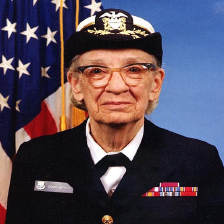

In [13]:
resized

In [14]:
wanted_type

UInt8

Note that the input data must be uint8 not float32.

In [ ]:
bounds := resized.Bounds()
dx, dy := bounds.Dx(), bounds.Dy()
bb := make([]byte, dx*dy*wanted_channels)
for y := 0; y < dy; y++ {
    for x := 0; x < dx; x++ {
        col := resized.At(x, y)
        r, g, b, _ := col.RGBA()
        bb[(y*dx+x)*3+0] = byte(float64(r) / 255.0)
        bb[(y*dx+x)*3+1] = byte(float64(g) / 255.0)
        bb[(y*dx+x)*3+2] = byte(float64(b) / 255.0)
    }
}
input.CopyFromBuffer(bb)

In [17]:
interpreter.Invoke()

OK

In [18]:
output := interpreter.GetOutputTensor(0)
output.NumDims()

2

The number of results are stored in the last element of output.

In [19]:
output_size := output.Dim(output.NumDims() - 1)
b := make([]byte, output_size)
output.CopyToBuffer(&b[0])

OK

The value in `b` is the scores for the each classes.

In [20]:
type result struct {
    score float64
    index int
}
results := []result{}
for i := 0; i < output_size; i++ {
    score := float64(b[i]) / 255.0
    if score < 0.1 {
        continue
    }
    results = append(results, result{score: score, index: i})
}

Then, sorting.

In [21]:
import "sort"

In [22]:
sort.Slice(results, func(i, j int) bool {
    return results[i].score > results[j].score
})

Now the `results` are sorted with order for scores. And index indicates index of lines in `labels.txt`.

In [23]:
func loadLabels(filename string) ([]string, error) {
    labels := []string{}
    f, err := os.Open("labels.txt")
    if err != nil {
        return nil, err
    }
    defer f.Close()
    scanner := bufio.NewScanner(f)
    for scanner.Scan() {
        labels = append(labels, scanner.Text())
    }
    return labels, nil
}

In [24]:
labels, err := loadLabels("labels.txt")
if err != nil {
    log.Fatal(err)
}

In [25]:
for i := 0; i < len(results); i++ {
    fmt.Printf("%02d: %s: %f\n", results[i].index, labels[results[i].index], results[i].score)
    if i > 5 {
        break
    }
}

653: military uniform: 0.768627
458: bow tie: 0.145098


One another example

In [29]:
import "net/http"

func whatIsThis(url string) {
    resp, err := http.Get(url)
    if err != nil {
        log.Fatal(err)
    }
    defer resp.Body.Close()
    img, _, err := image.Decode(resp.Body)
    if err != nil {
        log.Fatal(err)
    }
    resized := resize.Resize(uint(wanted_width), uint(wanted_height), img, resize.NearestNeighbor)
    bounds := resized.Bounds()
    dx, dy := bounds.Dx(), bounds.Dy()
    bb := make([]byte, dx*dy*wanted_channels)
    for y := 0; y < dy; y++ {
        for x := 0; x < dx; x++ {
            col := resized.At(x, y)
            r, g, b, _ := col.RGBA()
            bb[(y*dx+x)*3+0] = byte(float64(r) / 255.0)
            bb[(y*dx+x)*3+1] = byte(float64(g) / 255.0)
            bb[(y*dx+x)*3+2] = byte(float64(b) / 255.0)
        }
    }
    input.CopyFromBuffer(bb)
    interpreter.Invoke()
    output := interpreter.GetOutputTensor(0)
    output_size := output.Dim(output.NumDims() - 1)
    b := make([]byte, output_size)
    output.CopyToBuffer(&b[0])
    type result struct {
        score float64
        index int
    }
    results := []result{}
    for i := 0; i < output_size; i++ {
        score := float64(b[i]) / 255.0
        if score < 0.1 {
            continue
        }
        results = append(results, result{score: score, index: i})
    }
    sort.Slice(results, func(i, j int) bool {
        return results[i].score > results[j].score
    })
    for i := 0; i < len(results); i++ {
        fmt.Printf("%02d: %s: %f\n", results[i].index, labels[results[i].index], results[i].score)
        if i > 5 {
            break
        }
    }    
}

In [30]:
whatIsThis("https://images.pexels.com/photos/145897/pexels-photo-145897.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260")

85: peacock: 1.000000
